In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

df = pd.read_excel("BS_EN_Dataset.xlsx")

In [15]:
#Split columns to min and max
def split_row(row, elem): #row = df.iloc[[i]]
    min_ = row.reset_index()[elem][0].split("-")[0]
    max_ = row.reset_index()[elem][0].split("-")[1]
    return float(min_), float(max_)

def split_dataset(df):
    for elem in df.columns[5:20]:
        df = df.assign(min_ = lambda x: 0.0)
        df = df.assign(max_ = lambda x: 0.0)
        df.rename(columns = {"min_":"min_"+elem, "max_":"max_"+elem}, inplace = True)
        for i in range(len(df)):
            try:
                min_, max_ = split_row(df.iloc[[i]], elem)
                df.at[i, "min_"+elem] = min_
                df.at[i, "max_"+elem] = max_
            except:
                continue
    return df

df_split = split_dataset(df)

In [16]:
#Create expanded dataset
#Functions to expand rows
#yield or tensile is a range
def expand_row(row, feature, k): #row = df.iloc[[i]], i = 0:139
    feat_range = row.reset_index()[feature][0].split("-")
    feat_range = list(np.linspace(int(feat_range[0]), int(feat_range[1]), k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row[feature] = feat_range
    return row

#yield and tensile are ranges
def expand_row_2(row, k):
    yield_range = row.reset_index()["Yield Strength"][0].split("-")
    mean_yield = int((int(yield_range[0]) + int(yield_range[1])) / 2)
    row = row.reset_index()
    row.at[0, "Yield Strength"] = mean_yield
    return expand_row(row, "Tensile Strength", k)

#yield and tensile are not ranges
def expand_row_3(row, k):
    feat_range = list(np.linspace(row["Tensile Strength"] - 4, row["Tensile Strength"] + 5, k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row["Tensile Strength"] = feat_range
    return row

#Create expanded dataset
def expand_df(df, k):
    df2 = pd.DataFrame(columns=list(df.columns))
    for i in range(len(df)):
        row = df.iloc[[i]]
        if type(row.reset_index()["Tensile Strength"][0]) == str and type(row.reset_index()["Yield Strength"][0]) != str:
            expanded_row = expand_row(row, "Tensile Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row(row, "Yield Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) == str:
            expanded_row = expand_row_2(row, k)
        elif type(row.reset_index()["Yield Strength"][0]) != str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row_3(row, k)
        df2 = pd.concat([df2, expanded_row], ignore_index=True)
    return df2

df2 = expand_df(df_split, 70)

In [17]:
#Prepare data
from sklearn.model_selection import train_test_split

# change data types to integers
df2.Elongation = df2.Elongation.astype("int")
df2["Yield Strength"] = df2["Yield Strength"].astype("int")
df2["Tensile Strength"] = df2["Tensile Strength"].astype("int")

#normalize data
def normalize_data(df):
    df_min_max_scaled = df.copy()
    for column in df_min_max_scaled.columns[2:5]:
        df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
    x = df_min_max_scaled[df_min_max_scaled.columns[2:5]].values.tolist()
    return x

#split data
def split_data(output):
    x = normalize_data(df2)
    y = df2[output].values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    return x_train, x_test, y_train, y_test

#normalize new datapoint
def normalize_point(point, df_slice):
    for i in range(len(df_slice.columns)):
        point[i] = (point[i] - df_slice[df_slice.columns[i]].min()) / (df_slice[df_slice.columns[i]].max() - df_slice[df_slice.columns[i]].min())
    return np.array([point])

In [64]:
#Train regression models
#KNN regressor
from sklearn.neighbors import KNeighborsRegressor

#train model
def run_model_KNN_reg(n):
    scores = []
    for elem in df.columns[5:20]:
        print("\nFor the element: " + elem)
        
        x_train, x_test, y_train, y_test = split_data("min_"+elem)
        reg = KNeighborsRegressor(n_neighbors=n)
        reg.fit(x_train, y_train)
        print("Test set R^2 for "+"min_"+elem+": {:.2f}".format(reg.score(x_test, y_test)))
        scores.append(reg.score(x_test, y_test))
    
        x_train, x_test, y_train, y_test = split_data("max_"+elem)
        reg = KNeighborsRegressor(n_neighbors=n)
        reg.fit(x_train, y_train)
        print("Test set R^2 for "+"max_"+elem+": {:.2f}".format(reg.score(x_test, y_test)))
        scores.append(reg.score(x_test, y_test))
    average_score = sum(scores) / 30
    print("\nThe average score is: {:.2f}".format(average_score))
    return scores

scores = run_model_KNN_reg(10)


For the element: C
Test set R^2 for min_C: 0.98
Test set R^2 for max_C: 0.96

For the element: Si
Test set R^2 for min_Si: 0.54
Test set R^2 for max_Si: 0.79

For the element: Mn
Test set R^2 for min_Mn: 0.74
Test set R^2 for max_Mn: 0.80

For the element: P
Test set R^2 for min_P: 1.00
Test set R^2 for max_P: 0.91

For the element: S
Test set R^2 for min_S: 0.89
Test set R^2 for max_S: 0.89

For the element: N
Test set R^2 for min_N: 1.00
Test set R^2 for max_N: 0.53

For the element: Cu
Test set R^2 for min_Cu: 1.00
Test set R^2 for max_Cu: 0.80

For the element: Cr
Test set R^2 for min_Cr: 1.00
Test set R^2 for max_Cr: 0.74

For the element: Ni
Test set R^2 for min_Ni: 0.83
Test set R^2 for max_Ni: 0.85

For the element: Mo
Test set R^2 for min_Mo: 0.90
Test set R^2 for max_Mo: 0.87

For the element: Al
Test set R^2 for min_Al: 0.74
Test set R^2 for max_Al: 0.13

For the element: Ti
Test set R^2 for min_Ti: 1.00
Test set R^2 for max_Ti: 0.92

For the element: V
Test set R^2 for min

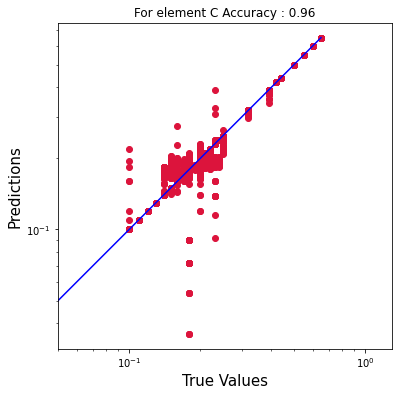

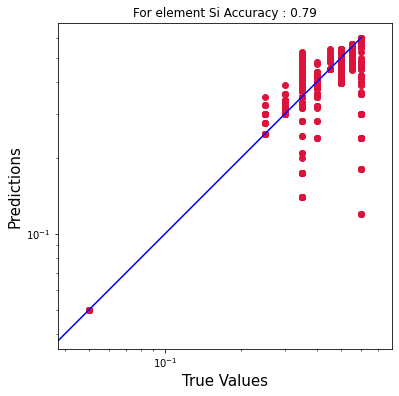

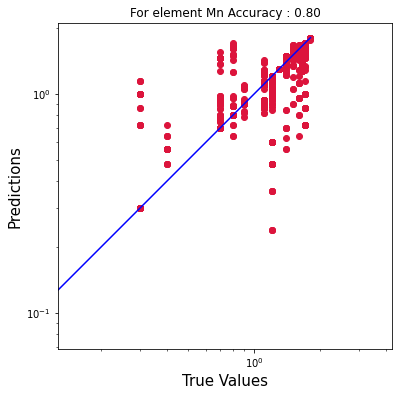

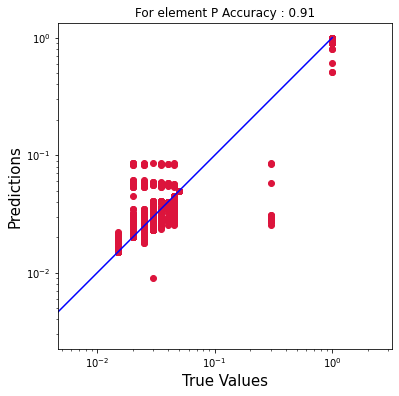

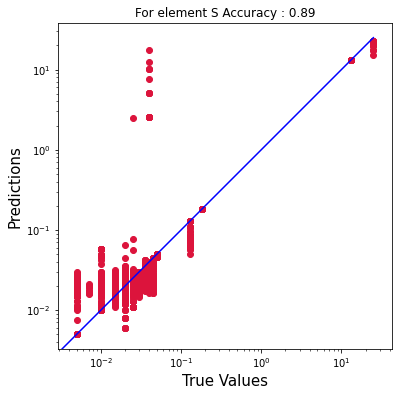

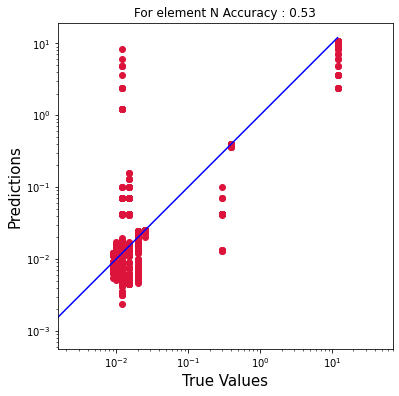

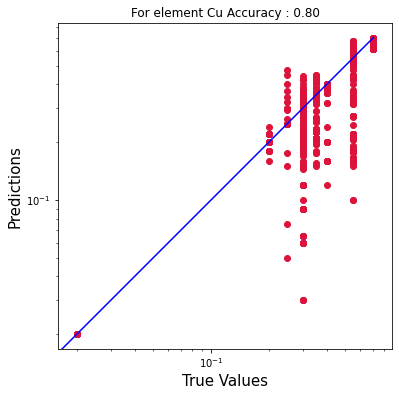

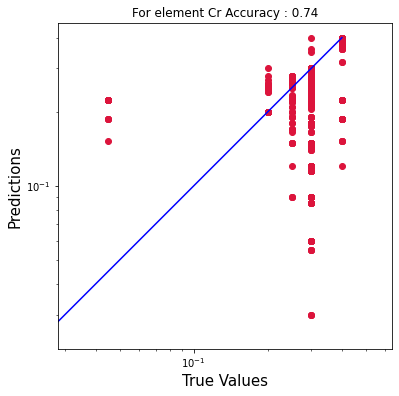

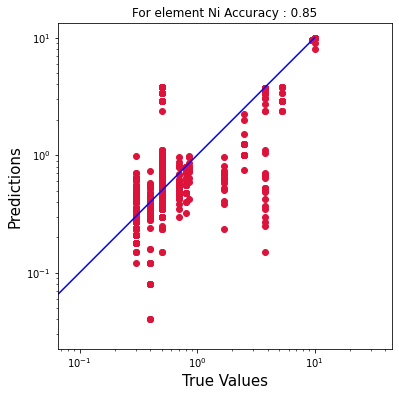

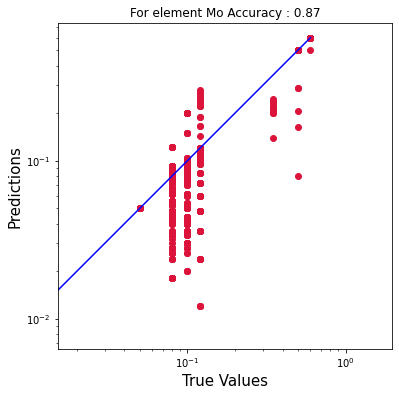

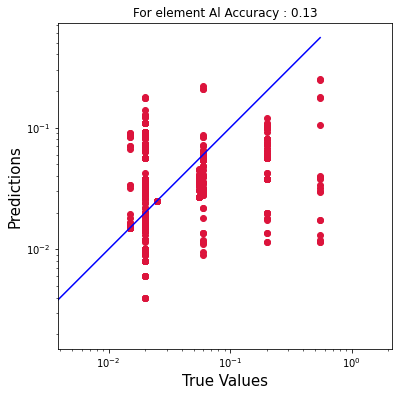

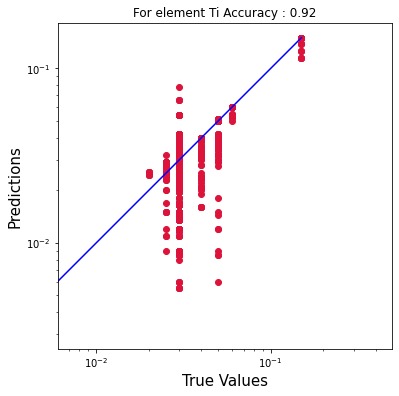

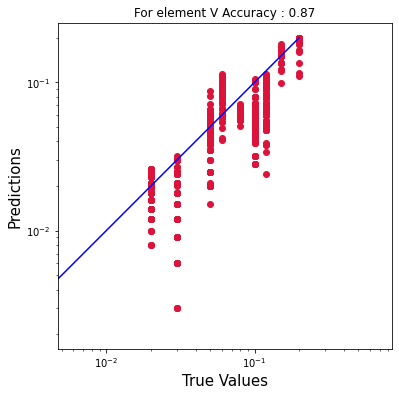

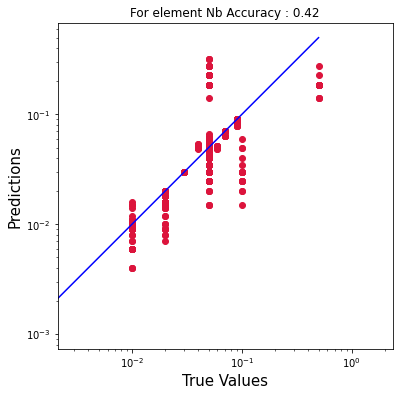

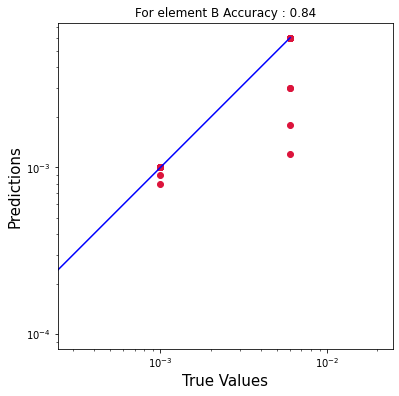

In [76]:
for elem in df.columns[5:20]:
    plt.figure(figsize=(6,6))
    x_train, x_test, y_train, y_test = split_data("max_"+elem)
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    plt.scatter(y_test, y_pred, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title("For element " + elem + " Accuracy : {:.2f}".format(reg.score(x_test, y_test)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()